In [1]:
## processing
import numpy as np
import pandas as pd

## custom scripts
import sys
sys.path.insert(1, '../src/tregseq/')
import footprint as fp
#import footprint_to_sites as f2s

## visualization
import matplotlib.pyplot as plt

In this notebook, we take in sequencing data in the form of RNA and DNA counts for each promoter variant and compute information footprint by calculating mutual information. We will first test the code on experimental datasets and then we will generate information footprint based on the synthetic datasets we made in `simple_repression_synthetic_dataset.ipynb`.

The mutual information between two random variables $X$ and $Y$ is defined as
$$
I(X;Y) = \sum_{y \in Y} \sum_{x \in X} P_{X,Y}(x,y) \log_2{(\frac{P_{X,Y}(x,y)}{P_X(x)P_Y(y)})},
$$
where $P_X$ is the marginal probability distribution of $X$, $P_Y$ is the marginal probability distribution of $Y$, and $P_{X,Y}$ is the joint probability distribution between $X$ and $Y$.

Here, the two random variables that we care about are base identity at each position and expression levels. Therefore we can rewrite the expression for the information footprint at each position $i$ as
$$
I(X;Y) = \sum_{b} \sum_{\mu} P_{i}(b, \mu) \log_2{(\frac{P_{i}(b, \mu)}{P_i(b)P(\mu)})},
$$
where $b$ represents base identity and $\mu$ represents expression levels.

We explore different ways of representing base identity and expression levels in probabilistic terms and ask which definition of mutual information produces the "best" information footprint.

There are two ways of representing base identity, $b$. If we are interested in which nucleotide is at each position in each promoter variant, then $b$ can be one of the four nucleotides, A, T, C, G. Alternatively, we might only be concerned with whether a mutation has occured i.e. whether the base identity at position $i$ in the promoter variant is different from the base identity in the wild type sequence. With this type of **coarse graining**, $b$ can take the values of
$$
b = 
\begin{cases}
    0, & \text{if the base is mutated} \\
    1, & \text{if the base is wild type}.
\end{cases}
$$. 

To represent expression levels as a probability distribution, we group sequences in each range of expression levels into discrete bins. The key question here is then what is the ideal method of binning the sequences. We begin by normalizing expression levels (RNA/DNA count) and choosing $n$ equal sized bins for the normalized counts.

## Loading sequencing data

The data is taken from `/RegSeq/data/sequencing_data/ykgE_dataset_combined.csv`, which contains DNA count (`ct_0`), RNA count (`ct_1`), and the total count (`ct`) for each promoter variant.

In [2]:
fpath = '../data/ykgE_dataset_combined.csv'
df_ykgE = pd.read_csv(fpath)
df_ykgE.head()

,ct,ct_0,ct_1,seq
0,1.0,1.0,0.0,ACAATTTCACCATAAAATGTCGGCGTTGCCGAAAGAAATAAAATGA...
1,1.0,1.0,0.0,ACGAATTCCCCATAAGAAGTAAGCGATGCAGAAAGAAATAAAATTA...
2,1.0,1.0,0.0,ACGAATTCCCCATAAGAAGTAAGCGATGCAGAAAGAAATAAAATTA...
3,2.0,2.0,0.0,ACGACTTGCCCAATAAATGTGAGCGTTGCCAAAAGGAATACAATGA...
4,2.0,2.0,0.0,ACGACTTGCCCAATAAATGTGAGCGTTGCCAAAAGGAATACAATGA...


The sequences in this dataset have an extra 20bp in the 3' end, so we trim it off before performing any analysis.

In [3]:
def trim_seqs(row):
    return row['seq'][:160]

In [4]:
df_ykgE['seq'] = df_ykgE.apply(trim_seqs, axis=1)

The main values that we care about here is the RNA count, but to account for the effect of multiple DNA templates on the expression levels, we "normalize" the RNA counts by dividing it by the DNA counts.

First we remove the rows with 0 DNA counts as they wouldn't be meaningful (since you cannot get mRNA without DNA) and would create division by 0 error.

In [5]:
df_ykgE = df_ykgE[df_ykgE.ct_0 != 0.0]

Now we perform the normalization.

In [6]:
df_ykgE['norm_ct_1'] = df_ykgE['ct_1'] / df_ykgE['ct_0']

In [7]:
df_ykgE.head()

,ct,ct_0,ct_1,seq,norm_ct_1
0,1.0,1.0,0.0,ACAATTTCACCATAAAATGTCGGCGTTGCCGAAAGAAATAAAATGA...,0.0
1,1.0,1.0,0.0,ACGAATTCCCCATAAGAAGTAAGCGATGCAGAAAGAAATAAAATTA...,0.0
2,1.0,1.0,0.0,ACGAATTCCCCATAAGAAGTAAGCGATGCAGAAAGAAATAAAATTA...,0.0
3,2.0,2.0,0.0,ACGACTTGCCCAATAAATGTGAGCGTTGCCAAAAGGAATACAATGA...,0.0
4,2.0,2.0,0.0,ACGACTTGCCCAATAAATGTGAGCGTTGCCAAAAGGAATACAATGA...,0.0


## Information footprint: Set-up 1

### 1. Representing mutations as probability distribution

Let's write down $P_i(b)$ by calculating the fraction of bases at each position that are wild type and the fraction that are mutated.

In [8]:
wtseq = 'TCGATTTCCCCATAAAATGTGAGCGATGCCGAAAGAAATAAAATTAGTTATTGCATTTGACGTTTGGATGAAAGATTATCATTTGTCATACAAATGAGGGGTGGTATGTTGCTAGCCAATTAAAAAAGAACGCCATATTTATTGATGATTGATCCCCCGG'

In [9]:
all_mutarr = fp.match_seqs(df_ykgE['seq'].values, wtseq)
all_mutarr

array([[1., 0., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 1., 0., 0.],
       [0., 1., 0., ..., 1., 0., 0.],
       [0., 1., 0., ..., 1., 0., 0.]])

In [10]:
cnt_seq = df_ykgE['norm_ct_1'].values
list_p_b = fp.get_pb(all_mutarr, cnt_seq)

In [11]:
list_p_b.shape

(160, 2)

### 2. Representing expression levels as probability distributions

To create the simplest probabilty distribution for expression levels, let's group RNA count into two bins - one with high expression levels and one with low expression levels.

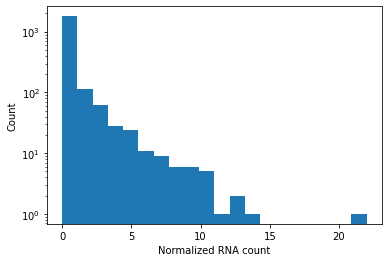

In [12]:
plt.hist(df_ykgE['norm_ct_1'], bins=20)
plt.xlabel('Normalized RNA count')
plt.ylabel('Count')
plt.yscale('log')
plt.show()

The above plot shows the distribution of the normalized RNA count, let's first arbitrarily say we have a highly expressed gene if the normalized RNA count is more than or equal to 2 and we have a lowly expressed gene otherwise. Then we can calculate $p_{\mu}$ as follows:

In [13]:
df_ykgE['highex'] = np.where(df_ykgE.norm_ct_1 >= 1, 1, 0)

In [14]:
df_ykgE.head()

,ct,ct_0,ct_1,seq,norm_ct_1,highex
0,1.0,1.0,0.0,ACAATTTCACCATAAAATGTCGGCGTTGCCGAAAGAAATAAAATGA...,0.0,0
1,1.0,1.0,0.0,ACGAATTCCCCATAAGAAGTAAGCGATGCAGAAAGAAATAAAATTA...,0.0,0
2,1.0,1.0,0.0,ACGAATTCCCCATAAGAAGTAAGCGATGCAGAAAGAAATAAAATTA...,0.0,0
3,2.0,2.0,0.0,ACGACTTGCCCAATAAATGTGAGCGTTGCCAAAAGGAATACAATGA...,0.0,0
4,2.0,2.0,0.0,ACGACTTGCCCAATAAATGTGAGCGTTGCCAAAAGGAATACAATGA...,0.0,0


In [15]:
cnt_seqs = len(df_ykgE)
cnt_highex = sum(df_ykgE['highex'])
prob_highex = cnt_highex / cnt_seqs

p_mu = [1 - prob_highex, prob_highex]
p_mu

[0.7905405405405406, 0.20945945945945946]

### 3. Calculating the joint probability distribution

In [16]:
ex_bins = df_ykgE['highex'].values

list_joint_p = []
for position in range(160):
    joint_p = np.zeros((2,2))

    for i in range(cnt_seqs):
        if (all_mutarr[i][position] == 0) & (ex_bins[i] == 0):
            joint_p[0][0] += 1
        elif (all_mutarr[i][position] == 1) & (ex_bins[i] == 0):
            joint_p[1][0] += 1
        elif (all_mutarr[i][position] == 0) & (ex_bins[i] == 1):
            joint_p[0][1] += 1
        else:
            joint_p[1][1] += 1

    joint_p /= np.sum(joint_p)
    list_joint_p.append(joint_p)

### 4. Calculate mutual information at each position

In [17]:
def MI(list_p_b, p_mu, list_joint_p, seqlen=160):

    mutual_info = []
    for position in range(seqlen):
        p_b = list_p_b[position]
        joint_p = list_joint_p[position]

        mi = joint_p[0][0] * np.log2(joint_p[0][0] / (p_b[0] * p_mu[0]))
        mi += joint_p[1][0] * np.log2(joint_p[1][0] / (p_b[1] * p_mu[0]))
        mi += joint_p[0][1] * np.log2(joint_p[0][1] / (p_b[0] * p_mu[1]))
        mi += joint_p[1][1] * np.log2(joint_p[1][1] / (p_b[1] * p_mu[1]))
        mutual_info.append(mi)
        
    return mutual_info

In [18]:
mutual_info = MI(list_p_b, p_mu, list_joint_p)

### 5. Making information footprint

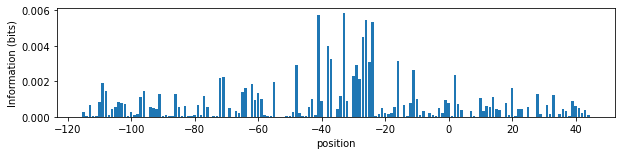

In [19]:
fig, ax = plt.subplots(figsize=(10,2))
ax.set_ylabel('Information (bits)')
ax.set_xlabel('position')

x = np.arange(-115, 45)
ax.bar(x, np.abs(mutual_info), edgecolor=None)
plt.show()

## Testing on simulated LacI data

In [20]:
fpath = '../data/synthetic_datasets/lacI_synthetic_dataset.csv'
df_lacI = pd.read_csv(fpath)
df_lacI.head()

,seq,pbound,ct_0,ct_1,ct
0,ACAGGTTTCCCGACTGGAAAGCGGGCAGTGAGCGCAACGCAATTAA...,0.000332,6.0,0.0,6.0
1,ACAGGTTTCCCGACTGGAAAGCGGGCAGTGAGCGCAACGCAATTAA...,0.000037,16.0,0.0,16.0
2,ACAGGTTTCCCGACTGGAAAGCGGGCAGTGAGCGCAACGCAATTAA...,0.000044,8.0,0.0,8.0
3,ACAGGTTTCCCGACTGGAAAGCGGGCAGTGAGCGCAACGCAATTAA...,0.000711,14.0,1.0,15.0
4,ACAGGTTTCCCGACTGGAAAGCGGGCAGTGAGCGCAACGCAATTAA...,0.000747,11.0,1.0,12.0


In [21]:
wtseq = 'ACAGGTTTCCCGACTGGAAAGCGGGCAGTGAGCGCAACGCAATTAATGTGAGTTAGCTCACTCATTAGGCACCCCAGGCTTTACACTTTATGCTTCCGGCTCGTATGTTGTGTGGAATTGTGAGCGGATAACAATTTCACACAGGAAACAGCTATGACCA'

In [22]:
df_lacI = df_lacI[df_lacI.ct_0 != 0.0]
df_lacI['norm_ct_1'] = df_lacI['ct_1'] / df_lacI['ct_0']

all_mutarr = fp.match_seqs(df_lacI['seq'].values, wtseq)
tot_mut_cnt = np.sum(all_mutarr, axis=0)
p_mut = tot_mut_cnt / len(df_lacI)
list_p_b = np.asarray([1 - p_mut, p_mut]).T

df_lacI['highex'] = np.where(df_lacI.norm_ct_1 >= 1, 1, 0)
cnt_seqs = len(df_lacI)
cnt_highex = sum(df_lacI['highex'])
prob_highex = cnt_highex / cnt_seqs
p_mu = [1 - prob_highex, prob_highex]

ex_bins = df_lacI['highex'].values

list_joint_p = []
for position in range(160):
    joint_p = np.zeros((2,2))
    for i in range(cnt_seqs):
        if (all_mutarr[i][position] == 0) & (ex_bins[i] == 0):
            joint_p[0][0] += 1
        elif (all_mutarr[i][position] == 1) & (ex_bins[i] == 0):
            joint_p[1][0] += 1
        elif (all_mutarr[i][position] == 0) & (ex_bins[i] == 1):
            joint_p[0][1] += 1
        else:
            joint_p[1][1] += 1
    joint_p /= np.sum(joint_p)
    list_joint_p.append(joint_p)

mutual_info = []
for position in range(160):
    p_b = list_p_b[position]
    joint_p = list_joint_p[position]

    mi = joint_p[0][0] * np.log2(joint_p[0][0] / (p_b[0] * p_mu[0]))
    mi += joint_p[1][0] * np.log2(joint_p[1][0] / (p_b[1] * p_mu[0]))
    mi += joint_p[0][1] * np.log2(joint_p[0][1] / (p_b[0] * p_mu[1]))
    mi += joint_p[1][1] * np.log2(joint_p[1][1] / (p_b[1] * p_mu[1]))
    mutual_info.append(mi)

/var/folders/dq/785ln7hn5m1_bmycnj08bnmh0000gn/T/ipykernel_21504/3057345069.py:40: RuntimeWarning: divide by zero encountered in log2
  mi += joint_p[1][1] * np.log2(joint_p[1][1] / (p_b[1] * p_mu[1]))
/var/folders/dq/785ln7hn5m1_bmycnj08bnmh0000gn/T/ipykernel_21504/3057345069.py:40: RuntimeWarning: invalid value encountered in double_scalars
  mi += joint_p[1][1] * np.log2(joint_p[1][1] / (p_b[1] * p_mu[1]))


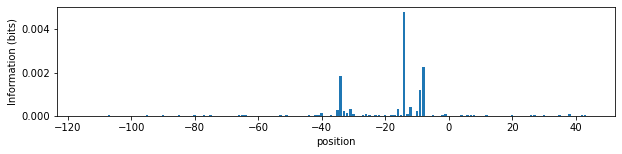

In [23]:
fig, ax = plt.subplots(figsize=(10,2))
ax.set_ylabel('Information (bits)')
ax.set_xlabel('position')

x = np.arange(-115, 45)
ax.bar(x, np.abs(mutual_info), edgecolor=None)
plt.show()